# Replicating medical cannabis laws and opioid overdose mortality study

[Bachhuber et al. (2014)](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/1898878) found that from 1999 to 2010 states with medical cannabis laws experienced slower increases in opioid analgesic overdose mortality.

[Shover et al. (2019)](https://www.pnas.org/doi/suppl/10.1073/pnas.1903434116#executive-summary-abstract) extend Bachhuber et al.’s analysis through 2017. They find that results from the original analysis do not hold over the longer period, and the association between state medical cannabis laws and opioid overdose mortality reversed direction from −21% to +23% and remained positive after accounting for recreational cannabis laws.

## Empirical Exercise in Stata

Note: The data used in the original article is public.

### Set Stata Magic in Python

In [15]:
%%capture
import os
os.chdir('/Program Files/Stata17/utilities')
from pystata import config
config.init('se')

### Import Data from Web

In [28]:
%%stata
gl data "C:\Users\edloaeza\Documents\GitHub\Marijuana"
* Import data
 import delimited "$data\pnas.1903434116.sd01.csv", clear


. gl data "C:\Users\edloaeza\Documents\GitHub\Marijuana"

. * Import data
.  import delimited "$data\pnas.1903434116.sd01.csv", clear
(encoding automatically selected: ISO-8859-1)
(25 vars, 947 obs)

. 


In [30]:
%%stata
des


Contains data
 Observations:           947                  
    Variables:            36                  
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
state_name      str24   %24s                  
year            float   %8.0g                 Year
deaths          int     %8.0g                 Deaths
population      long    %12.0g                Population
crude_rate      float   %9.0g                 Crude_Rate
age_adjusted_~e float   %9.0g                 Age_Adjusted_Rate
ag~wer_95__conf float   %9.0g                 Age_Adjusted_Rate_Lower_95__Conf
ag~per_95__conf float   %9.0g                 Age_Adjusted_Rate_Upper_95__Conf
ln_crude_mort~e float   %9.0g                 
crude_rate_lo~e float   %9.0g                 Crude_Rate_Lower_95__Confidence
crude_rate_up~e f

### Create initial variables

In [29]:
%%stata
ren state state_name
merge m:1 state_name using "$data\state_names_codes.dta", keepus(state_abbr state_fips) ///
    keep(match master) nogen
ren state_abbr state

* Bring dates of legalization
merge 1:1 state year using "$data\Medical Marijuana Policy Data\WEB_MJ Policy.dta", ///
    keep(match master) nogen
ren state state_abbr

sort state_fips year
xtset state_fips year


. ren state state_name

. merge m:1 state_name using "$data\state_names_codes.dta", keepus(state_abbr s
> tate_fips) ///
>     keep(match master) nogen
(variable state_name was str14, now str24 to accommodate using data's values)

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                               947  
    -----------------------------------------

. ren state_abbr state

. 
. * Bring dates of legalization
. merge 1:1 state year using "$data\Medical Marijuana Policy Data\WEB_MJ Policy
> .dta", ///
>     keep(match master) nogen
(variable state was str2, now str6 to accommodate using data's values)
(variable year was int, now float to accommodate using data's values)

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                               947  
    --------------------

### Estimates for the original 1999–2010 time period

In [10]:
%%stata
gl origcontrols unemployment rxdmp_original rxid_original pmlaw_original
eststo clear
reghdfe ln_age_mort_rate medical_cannabis_law $origcontrols if year<=2010, a(state_id year) vce(r)
est store reg1
qui: estadd local t "1999-2010", replace


. gl origcontrols unemployment rxdmp_original rxid_original pmlaw_original

. eststo clear

. reghdfe ln_age_mort_rate medical_cannabis_law $origcontrols if year<=2010, a(
> state_id year) vce(r)
(MWFE estimator converged in 5 iterations)

HDFE Linear regression                            Number of obs   =        575
Absorbing 2 HDFE groups                           F(   5,    509) =       3.77
                                                  Prob > F        =     0.0023
                                                  R-squared       =     0.8665
                                                  Adj R-squared   =     0.8494
                                                  Within R-sq.    =     0.0342
                                                  Root MSE        =     0.2914

------------------------------------------------------------------------------
             |               Robust
ln_age_mor~e | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-----------

### Using the full 1999–2017 dataset

In [11]:
%%stata
gl controls unemployment rxdmp_update pmlaw_update rxid_update
eststo clear
reghdfe ln_age_mort_rate medical_cannabis_law $controls, a(state_id year) vce(r)
est store reg2
qui: estadd local t "1999-2017", replace


. gl controls unemployment rxdmp_update pmlaw_update rxid_update

. eststo clear

. reghdfe ln_age_mort_rate medical_cannabis_law $controls, a(state_id year) vce
> (r)
(MWFE estimator converged in 5 iterations)

HDFE Linear regression                            Number of obs   =        908
Absorbing 2 HDFE groups                           F(   5,    835) =       6.94
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.8169
                                                  Adj R-squared   =     0.8012
                                                  Within R-sq.    =     0.0422
                                                  Root MSE        =     0.3516

------------------------------------------------------------------------------
             |               Robust
ln_age_mor~e | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+-------------------------

In [12]:
%%stata
esttab reg1 reg2, label se star(* 0.10 ** 0.05 *** 0.01) ///
title("Age-adjusted opioid overdose death rate per 100,000 population") ///
stats(t N, ///
label("Period ""Observations"))


. esttab reg1 reg2, label se star(* 0.10 ** 0.05 *** 0.01) ///
> title("Age-adjusted opioid overdose death rate per 100,000 population") ///
> stats(t N, ///
> label("Period ""Observations"))

Age-adjusted opioid overdose death rate per 100,000 population
----------------------------------------------------
                              (1)             (2)   
                     ln_age_mor~e    ln_age_mor~e   
----------------------------------------------------
Medical_Cannabis_Law       -0.237***        0.194***
                         (0.0732)        (0.0564)   

unemployment               0.0430**        0.0174   
                         (0.0177)        (0.0152)   

rxdmp_original            -0.0286                   
                         (0.0498)                   

rxid_original              0.0279                   
                         (0.0527)                   

pmlaw_original            -0.0716                   
                          (0.100)                 


. egen withlaw=max( medical_cannabis_law), by(state_id)

. gen nolaw= withlaw==0

. collapse (mean) age_adjusted_rate, by(year nolaw)

. reshape wide age_adjusted_rate, i(year) j( nolaw)
(j = 0 1)

Data                               Long   ->   Wide
-----------------------------------------------------------------------------
Number of observations               38   ->   19          
Number of variables                   3   ->   3           
j variable (2 values)             nolaw   ->   (dropped)
xij variables:
                      age_adjusted_rate   ->   age_adjusted_rate0 age_adjusted_
> rate1
-----------------------------------------------------------------------------

. tsline age_adjusted_rate0 if year<=2010 || tsline age_adjusted_rate1 if year<
> =2010

. 


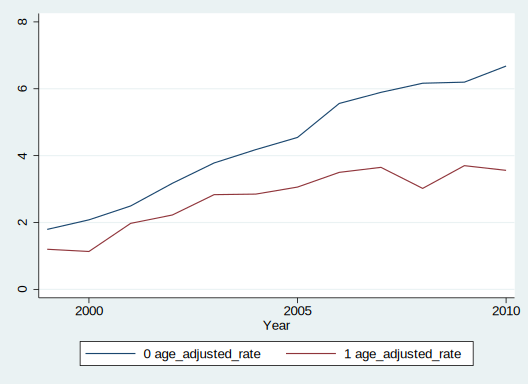

In [13]:
%%stata
egen withlaw=max( medical_cannabis_law), by(state_id)
gen nolaw= withlaw==0
collapse (mean) age_adjusted_rate, by(year nolaw)
reshape wide age_adjusted_rate, i(year) j( nolaw)
tsline age_adjusted_rate0 if year<=2010 || tsline age_adjusted_rate1 if year<=2010